---
<h1 align="center"><strong>Semantic Similarity CamemBERT+(Bi)LSTM+Mean Pooling</strong><h1>
<h2 align="center"><b>----Cross Encoder---</strong><h2>

---

In [ ]:
!pip install transformers -q
!pip install SentencePiece -q
!pip install datasets -q

     |████████████████████████████████| 4.4 MB 5.1 MB/s 
     |████████████████████████████████| 86 kB 1.3 MB/s 
     |████████████████████████████████| 6.6 MB 52.5 MB/s 
     |████████████████████████████████| 596 kB 48.6 MB/s 
     |████████████████████████████████| 1.2 MB 5.1 MB/s 
     |████████████████████████████████| 362 kB 4.8 MB/s 
     |████████████████████████████████| 1.1 MB 65.6 MB/s 
     |████████████████████████████████| 212 kB 70.3 MB/s 
     |████████████████████████████████| 140 kB 70.2 MB/s 
     |████████████████████████████████| 127 kB 72.3 MB/s 
     |████████████████████████████████| 271 kB 73.3 MB/s 
     |████████████████████████████████| 94 kB 3.5 MB/s 
     |████████████████████████████████| 144 kB 73.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is 

### Required libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn import model_selection, metrics

from tqdm import tqdm
from collections import defaultdict

import warnings
warnings.filterwarnings("ignore")

from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
import scipy

### Utils

In [ ]:
def convert_dataset(dataset):
  dataset_samples= pd.DataFrame(columns = ["sentence1","sentence2", "similarity_score"])
  for df in dataset:
    score = float(df['similarity_score'])/5.0
    dataset_samples = dataset_samples.append(df, ignore_index = True)
  dataset_samples['similarity_score']= dataset_samples.apply(lambda col: float(col.similarity_score)/5.0, axis=1)
  return dataset_samples

def get_sts_df(df_train, df_valid, df_test):
  train_samples = convert_dataset(df_train)
  dev_samples = convert_dataset(df_valid)
  test_samples = convert_dataset(df_test)

  #df = pd.concat([train_samples, dev_samples, test_samples], axis=0)
  df = pd.concat([train_samples, dev_samples], axis=0)
  df.reset_index(drop=True, inplace=True)
  #df["similarity_score"] = df["similarity_score"].apply(lambda score: 1 if score> 0.5 else 0)
  return df, test_samples

In [ ]:
df_train = load_dataset("stsb_multi_mt", name="fr", split="train")
df_valid = load_dataset("stsb_multi_mt", name="fr", split="dev")
df_test = load_dataset("stsb_multi_mt", name="fr", split="test")

df, test_samples = get_sts_df(df_train, df_valid, df_test)
df.to_csv("sts.csv")

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Dataset stsb_multi_mt downloaded and prepared to /root/.cache/huggingface/datasets/stsb_multi_mt/fr/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9. Subsequent calls will reuse this data.


Reusing dataset stsb_multi_mt (/root/.cache/huggingface/datasets/stsb_multi_mt/fr/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9)
Reusing dataset stsb_multi_mt (/root/.cache/huggingface/datasets/stsb_multi_mt/fr/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9)


In [ ]:
class Config:
  #MAX_LEN = 90
  MAX_LEN = 128
  TRAIN_BATCH_SIZE = 8
  VALID_BATCH_SIZE = 4
  EPOCHS = 2
  DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  CamemeBERT_PATH = "camembert-base"
  MODEL_LSTM_PATH2 = "stscamembertLstmModel2.bin"
  MODEL_LSTM_PATH = "stscamembertLstmModel.bin"
  TRAINING_DATA = "sts.csv"

  TOKENIZER = transformers.CamembertTokenizer.from_pretrained(CamemeBERT_PATH, do_lower_case = True)
  MODEL = transformers.CamembertModel.from_pretrained(CamemeBERT_PATH, return_dict=False)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Dataset

In [ ]:
class DataProcess:
  def __init__(self, sent1, sent2):
    self.tokenizer = Config.TOKENIZER
    self.max_len = Config.MAX_LEN

    self.sent1 = sent1
    self.sent2 = sent2
    
  def preprocess_bert(self):
    sent1 = " ".join(self.sent1.split())
    sent2 = " ".join(self.sent2.split())
    inputs = self.tokenizer.encode_plus(
        sent1,
        sent2,
        add_special_tokens=True,
        max_length=self.max_len,
        # padding = "max_length",
        truncation=True
        )

    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    return (
        torch.tensor(input_ids, dtype=torch.long).unsqueeze(0),
        torch.tensor(attention_mask, dtype=torch.long).unsqueeze(0)
        )
    
  def preprocess_output(self, outputs):
    outputs = outputs.cpu().detach().numpy()
    return outputs


class STS:
  def __init__(self,  sent1, sent2, label):
    self.sent1 = sent1
    self.sent2 = sent2
    
    self.label = label
    self.max_len = Config.MAX_LEN
    self.tokenizer = Config.TOKENIZER
  
  def __len__(self):
    return len(self.sent1)
  
  def __getitem__(self, item):
    sent1 = str(self.sent1[item])
    sent1 = " ".join(sent1.split())

    sent2 = str(self.sent2[item])
    sent2 = " ".join(sent2.split())

    inputs = self.tokenizer.encode_plus(
        sent1,
        sent2,
        add_special_tokens=True,
        max_length=self.max_len,
        padding="max_length",
        truncation=True
    )

    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    return {
        "input_ids" : torch.tensor(input_ids, dtype=torch.long),
        "attention_mask" : torch.tensor(attention_mask, dtype=torch.long),
        "labels" : torch.tensor(self.label[item], dtype=torch.float)
    }

### Cross Model

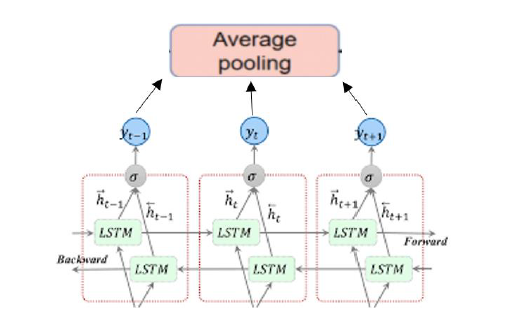

## Cross Encoder : Camembert + BiLSTM + MeanPooling

In [ ]:
import torch 

In [ ]:
class CamemBERTLstmModel(nn.Module):
  def __init__(self):
    super(CamemBERTLstmModel, self).__init__()
    
    self.camembert = Config.MODEL
    self.bilstm = nn.LSTM(768, 768, batch_first=True,  bidirectional=True)
    self.camembert_drop = nn.Dropout(0.2)
    self.regressor = nn.Linear(768*2, 1)

  def forward(self, input_ids, attention_mask):
    sequence_output, pooled_output = self.camembert(input_ids=input_ids, attention_mask=attention_mask)

    lstm_output, (h,c) = self.bilstm(sequence_output)
    # global average pooling
    avg_pool = torch.mean(lstm_output, 1)

    output = self.regressor(avg_pool)
    
    return output

In [ ]:
def loss_fn(outputs, labels):
  return nn.MSELoss()(outputs, labels.view(-1, 1))

def train_fn(train_dataloader, model, optimizer, device, scheduler):
  model.train()
  final_loss = 0

  fin_labels = []
  fin_outputs = []
  for bi, d in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
    input_ids = d["input_ids"]
    attention_mask = d["attention_mask"]
    labels = d["labels"]

    input_ids = input_ids.to(device, dtype=torch.long)
    attention_mask = attention_mask.to(device, dtype=torch.long)
    labels = labels.to(device, dtype = torch.float)

    optimizer.zero_grad()
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    loss = loss_fn(outputs, labels)
    
    final_loss += loss.item()
    fin_labels.extend(labels.cpu().detach().numpy().tolist())
    #fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    fin_outputs.extend(outputs.cpu().detach().numpy().tolist())
    
    loss.backward()
    optimizer.step()
    scheduler.step()

  return fin_outputs, fin_labels, final_loss/len(train_dataloader)

def eval_fn(valid_dataloader, model, device):
  model.eval()
  final_loss = 0

  fin_labels = []
  fin_outputs = []
  with torch.no_grad():
    for bi, d in tqdm(enumerate(valid_dataloader), total=len(valid_dataloader)):
      input_ids = d["input_ids"]
      attention_mask = d["attention_mask"]
      labels = d["labels"]

      input_ids = input_ids.to(device, dtype=torch.long)
      attention_mask = attention_mask.to(device, dtype=torch.long)
      labels = labels.to(device, dtype = torch.float)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      
      loss = loss_fn(outputs, labels)
      final_loss += loss.item()
      
      fin_labels.extend(labels.cpu().detach().numpy().tolist())
      #fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
      fin_outputs.extend(outputs.cpu().detach().numpy().tolist())
      

  return fin_outputs, fin_labels, final_loss/len(valid_dataloader)

In [ ]:
#dfx = pd.read_csv(Config.TRAINING_DATA).fillna("none")
df_train = pd.read_csv(Config.TRAINING_DATA).fillna("none")
df_valid = test_samples

'''df_train, df_valid = model_selection.train_test_split(
    dfx, test_size=0.2, random_state=42) #stratify=dfx.similarity_score.values)'''

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

train_dataset = STS(
    sent1=df_train.sentence1.values, 
    sent2=df_train.sentence2.values, 
    label=df_train.similarity_score.values
)
train_dataloader = DataLoader(train_dataset, batch_size=Config.TRAIN_BATCH_SIZE, num_workers=4)

valid_dataset = STS(
    sent1=df_valid.sentence1.values, 
    sent2=df_valid.sentence2.values, 
    label=df_valid.similarity_score.values
)
valid_dataloader = DataLoader(valid_dataset, batch_size=Config.VALID_BATCH_SIZE, num_workers=1)

model_lstm = CamemBERTLstmModel()
model_lstm.to(Config.DEVICE)

param_optimizer = list(model_lstm.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
                        {
                            "params": [
                                       p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                                       ],
                         "weight_decay": 0.001,
                         },
                        {
                            "params": [
                                       p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                                       ],
                         "weight_decay": 0.0,
                         },
                        ]

num_train_steps = int(len(df_train) / Config.TRAIN_BATCH_SIZE * Config.EPOCHS)
optimizer = AdamW(optimizer_parameters, lr=3e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
    )

In [ ]:
history2 = defaultdict(list)
best_accuracy = 0
for epoch in range(1, 3):
  train_outputs, train_labels, train_loss = train_fn(train_dataloader, model_lstm, optimizer, Config.DEVICE, scheduler)
  valid_outputs, valid_labels, valid_loss = eval_fn(valid_dataloader, model_lstm, Config.DEVICE)

  train_accuracy = metrics.r2_score(train_labels, train_outputs)
  valid_accuracy = metrics.r2_score(valid_labels, valid_outputs)
  train_pearson_corr = scipy.stats.pearsonr(train_labels, train_outputs)[0][0]
  valid_pearson_corr= scipy.stats.pearsonr(valid_labels, valid_outputs)[0][0]

  print(f"Epoch: {epoch}\nTrain Loss: {train_loss} - Train r2_score: {train_accuracy} - Train pearson Correlation: {train_pearson_corr} \nValid Loss: {valid_loss} - Valid r2_score: {valid_accuracy}- Valid pearson Correlation: {valid_pearson_corr}\n")
  
  history2['Train Loss'].append(train_loss)
  history2['Train Accuracy'].append(train_accuracy)
  history2['Valid Loss'].append(valid_loss)
  history2['Valid Accuracy'].append(valid_accuracy)
  history2['Train Pearson correlation'].append(train_pearson_corr)
  history2['Valid Pearson correlation'].append(valid_pearson_corr)
  
  if valid_pearson_corr > best_accuracy:
    torch.save(model_lstm.state_dict(), Config.MODEL_LSTM_PATH)
    best_accuracy = valid_pearson_corr

100%|██████████| 345/345 [00:15<00:00, 22.01it/s]


Epoch: 1
Train Loss: 0.019607883480032486 - Train r2_score: 0.7754352409804743 - Train pearson Correlation: 0.8810531816938773 
Valid Loss: 0.032031645182776604 - Valid r2_score: 0.6554093753449179- Valid pearson Correlation: 0.836450815165328



100%|██████████| 345/345 [00:15<00:00, 22.03it/s]


Epoch: 2
Train Loss: 0.010551774132326287 - Train r2_score: 0.8791403558425237 - Train pearson Correlation: 0.9376546535494268 
Valid Loss: 0.026951323728502282 - Valid r2_score: 0.71006461799806- Valid pearson Correlation: 0.8467852472762734



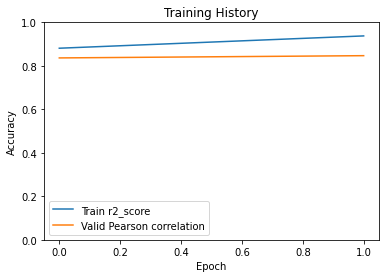

In [ ]:
plt.plot(history2['Train Pearson correlation'], label='Train Pearson correlation')
plt.plot(history2['Valid Pearson correlation'], label='Valid Pearson correlation')
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

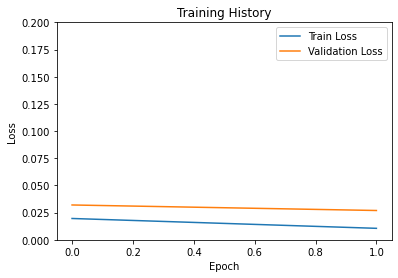

In [ ]:
plt.plot(history2['Train Loss'], label='Train Loss')
plt.plot(history2['Valid Loss'], label='Validation Loss')
plt.title('Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.2]);

### Inference

In [ ]:
model_lstm = CamemBERTLstmModel()
model_lstm.to(Config.DEVICE)
model_lstm.load_state_dict(
    torch.load(
        Config.MODEL_LSTM_PATH,
        map_location=torch.device(Config.DEVICE)
        )
    )

def predict(sent1: str, sent2: str):
  data = DataProcess(sent1, sent2)
  input_ids, attention_mask = data.preprocess_bert()
  
  input_ids = input_ids.to(Config.DEVICE, dtype=torch.long)
  attention_mask = attention_mask.to(Config.DEVICE, dtype=torch.long)
  
  output = model_lstm(input_ids, attention_mask)
  similarity_score = data.preprocess_output(output)
  
  return {
      "sentence1": sent1,
      "sentence2": sent2,
      "similarity Score": str(similarity_score)
      #"no similarity Score": str(no_similarity_Score),
  }

In [ ]:
sentence1 = "je suis heureux"
sentence2 = "je suis triste"

similarity_score = predict(sentence1, sentence2)
print(similarity_score)

{'sentence1': 'je suis heureux', 'sentence2': 'je suis triste', 'similarity Score': '[[0.30790436]]'}


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
faq = pd.read_excel('/content/drive/MyDrive/FAQ-CMR.xlsx')
faq.head()

,Question,Réponse,Catégorie
0,"Je suis un fonctionnaire, comment m’affilier a...",Vous n'avez aucune démarche à faire pour cette...,Affiliation
1,J’étais un agent dans une collectivité territo...,"Oui, toutefois, vous devez informer votre Adm...",Affiliation
2,La date de naissance portée sur mon attestatio...,"En cas de discordance, merci de contacter votr...",Affiliation
3,Quelles sont les conditions nécessaires pour l...,Tous les affiliés aux régimes de base de gérés...,Attakmili
4,Quel est la cotisation minimale au titre du Ré...,La cotisation minimale est de 50 DHS,Attakmili


In [ ]:
query = " est ce que je peux modifier mon nom ?"

def predict_(sent1: str, sent2: str):
  data = DataProcess(sent1, sent2)
  input_ids, attention_mask = data.preprocess_bert()
  
  input_ids = input_ids.to(Config.DEVICE, dtype=torch.long)
  attention_mask = attention_mask.to(Config.DEVICE, dtype=torch.long)
  
  outputs = model_lstm(input_ids, attention_mask)
  similarity_score = data.preprocess_output(outputs) 
  
  return similarity_score

question=[]
scores = []
for idx in range(faq.shape[0]):
  score = predict_(query,str(faq['Question'][idx]))[0][0]
  scores.append(score)
  question.append(faq['Question'][idx])
  


In [ ]:
df = pd.DataFrame(list(zip(question, scores)),
               columns =['Question', 'similarity_score'])
df.sort_values(by='similarity_score', axis=0, ascending=False).head(5)

,Question,similarity_score
29,Comment faut-il procéder pour changer mon nom ?,0.689930
28,Comment faut-il procéder pour rectifier mon nom?,0.528473
20,Quand est-ce que je bénéficierais du premier p...,0.418006
76,Je suis bénéficiaire d'une pension de retraire...,0.415372
40,Quelles sont les pièces à fournir à la CMR pou...,0.410442


### CamemBERT LSTM + MeanPooling

In [ ]:
class CamemBERTLstmModel2(nn.Module):
  def __init__(self):
    super(CamemBERTLstmModel2, self).__init__()
    self.camembert = Config.MODEL
    self.lstm = nn.LSTM(768, 768, batch_first=True)
    self.camembert_drop = nn.Dropout(0.2)
    self.regressor = nn.Linear(768, 1)

  def forward(self, input_ids, attention_mask):
    sequence_output, pooled_output = self.camembert(input_ids=input_ids, attention_mask=attention_mask)
    lstm_output, (h,c) = self.lstm(sequence_output)
    
    # global average pooling
    avg_pool = torch.mean(lstm_output, 1)
  
    output = self.regressor(avg_pool)
    
    return output

In [ ]:
#dfx = pd.read_csv(Config.TRAINING_DATA).fillna("none")
df_train = pd.read_csv(Config.TRAINING_DATA).fillna("none")
df_valid = test_samples

'''df_train, df_valid = model_selection.train_test_split(
    dfx, test_size=0.2, random_state=42) #stratify=dfx.similarity_score.values)'''

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

train_dataset = STS(
    sent1=df_train.sentence1.values, 
    sent2=df_train.sentence2.values, 
    label=df_train.similarity_score.values
)
train_dataloader = DataLoader(train_dataset, batch_size=Config.TRAIN_BATCH_SIZE, num_workers=4)

valid_dataset = STS(
    sent1=df_valid.sentence1.values, 
    sent2=df_valid.sentence2.values, 
    label=df_valid.similarity_score.values
)
valid_dataloader = DataLoader(valid_dataset, batch_size=Config.VALID_BATCH_SIZE, num_workers=1)

model_lstm2 = CamemBERTLstmModel2()
model_lstm2.to(Config.DEVICE)

param_optimizer = list(model_lstm2.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
                        {
                            "params": [
                                       p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                                       ],
                         "weight_decay": 0.001,
                         },
                        {
                            "params": [
                                       p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                                       ],
                         "weight_decay": 0.0,
                         },
                        ]

num_train_steps = int(len(df_train) / Config.TRAIN_BATCH_SIZE * Config.EPOCHS)
optimizer = AdamW(optimizer_parameters, lr=3e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
    )

In [ ]:
history = defaultdict(list)
best_accuracy = 0
for epoch in range(1, 3):
  train_outputs, train_labels, train_loss = train_fn(train_dataloader, model_lstm2, optimizer, Config.DEVICE, scheduler)
  valid_outputs, valid_labels, valid_loss = eval_fn(valid_dataloader, model_lstm2, Config.DEVICE)

  train_accuracy = metrics.r2_score(train_labels, train_outputs)
  valid_accuracy = metrics.r2_score(valid_labels, valid_outputs)
  train_pearson_corr = scipy.stats.pearsonr(train_labels, train_outputs)[0][0]
  valid_pearson_corr= scipy.stats.pearsonr(valid_labels, valid_outputs)[0][0]

  print(f"Epoch: {epoch}\nTrain Loss: {train_loss} - Train r2_score: {train_accuracy} - Train pearson Correlation: {train_pearson_corr} \nValid Loss: {valid_loss} - Valid r2_score: {valid_accuracy}- Valid pearson Correlation: {valid_pearson_corr}\n")
  
  history['Train Loss'].append(train_loss)
  history['Train Accuracy'].append(train_accuracy)
  history['Valid Loss'].append(valid_loss)
  history['Valid Accuracy'].append(valid_accuracy)
  history['Train Pearson correlation'].append(train_pearson_corr)
  history['Valid Pearson correlation'].append(valid_pearson_corr)
  
  if valid_pearson_corr > best_accuracy:
    torch.save(model_lstm2.state_dict(), Config.MODEL_LSTM_PATH2)
    best_accuracy = valid_pearson_corr

100%|██████████| 345/345 [00:14<00:00, 23.75it/s]


Epoch: 1
Train Loss: 0.0135939508546765 - Train r2_score: 0.844293197900957 - Train pearson Correlation: 0.9192384588674052 
Valid Loss: 0.03680317470824103 - Valid r2_score: 0.6040937537402682- Valid pearson Correlation: 0.8378063972630132



100%|██████████| 345/345 [00:13<00:00, 24.91it/s]


Epoch: 2
Train Loss: 0.007648849724967786 - Train r2_score: 0.9123893146051231 - Train pearson Correlation: 0.9552315004343951 
Valid Loss: 0.028297690826930455 - Valid r2_score: 0.6955883283996096- Valid pearson Correlation: 0.8421063543156544



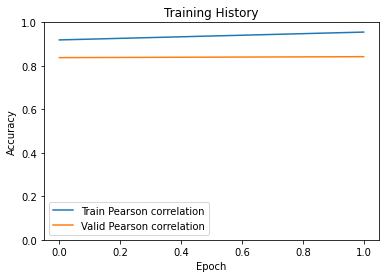

In [ ]:
plt.plot(history['Train Pearson correlation'], label='Train Pearson correlation')
plt.plot(history['Valid Pearson correlation'], label='Valid Pearson correlation')
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

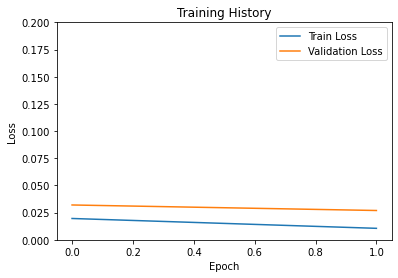

In [ ]:
plt.plot(history['Train Loss'], label='Train Loss')
plt.plot(history['Valid Loss'], label='Validation Loss')
plt.title('Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.2]);

### References
* **Louis Martin, Benjamin Muller, Pedro Javier Ortiz Suárez, Yoann Dupont, Laurent Romary, Éric Villemonte de la Clergerie, Djamé Seddah, Benoît Sagot. 2019. [CamemBERT: a Tasty French Language Model](https://arxiv.org/abs/1911.03894). arXiv preprint arXiv:1911.03894**